**Examples**

Torque

In [1]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

download('https://raw.githubusercontent.com/AllenDowney/' +
         'ModSimPy/master/modsim.py')

Downloaded modsim.py


In [2]:
from modsim import *

Teapots and Turntables

In [8]:
from numpy import pi
radius_disk = 0.5     # m
mass_disk = 7         # kg
radius_pot = 0.4      # m
mass_pot = 0.3        # kg
force = 2             # N
theta_push = 0.5        # radian
theta_test = 1.5        # radian
theta_target = pi       # radian
I_disk = mass_disk * radius_disk**2 / 2
I_pot = mass_pot * radius_pot**2
I_total = I_disk + I_pot
torque_friction = 0.3   # N*m
init = State(theta=0, omega=0)
system = System(init=init,
                force=force,
                torque_friction=torque_friction,
                t_end=20)

In [9]:
def slope_func(t, state, system):
    theta, omega = state
    force = system.force
    torque_friction = system.torque_friction

    torque = radius_disk * force - torque_friction
    alpha = torque / I_total

    return omega, alpha
slope_func(0, system.init, system)

(0, 0.7583965330444203)

Two Phase Simulation

Phase 1

In [10]:
def event_func1(t, state, system):
    theta, omega = state
    return theta - theta_push
event_func1(0, system.init, system)
results1, details1 = run_solve_ivp(system, slope_func, events=event_func1)
details1.message

'A termination event occurred.'

In [11]:
results1.tail()

,theta,omega
1.102359,0.46080,0.836025
1.113842,0.47045,0.844734
1.125325,0.48020,0.853442
1.136808,0.49005,0.862151
1.148291,0.50000,0.870860


In [12]:
t_2 = results1.index[-1]
init2 = results1.iloc[-1]

Phase 2

In [13]:
system2 = system.set(t_0=t_2, init=init2, force=0)
def event_func2(t, state, system):
    theta, omega = state
    return omega
event_func2(system2.t_0, system2.init, system2)
results2, details2 = run_solve_ivp(system2, slope_func, events=event_func2)
details2.message

'A termination event occurred.'

Combining the Results

In [14]:
results = pd.concat([results1, results2])
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


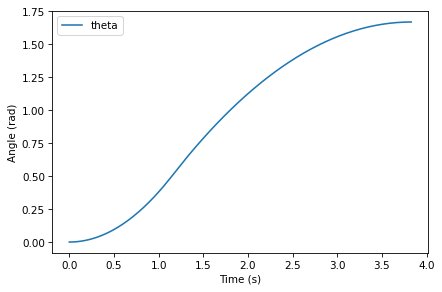

In [15]:
results.theta.plot(label='theta')
decorate(xlabel='Time (s)', ylabel='Angle (rad)')

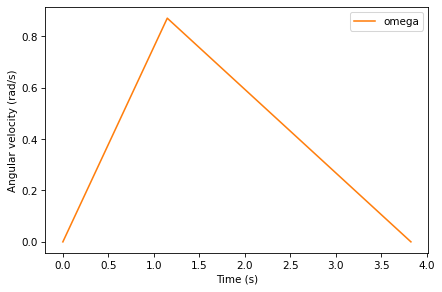

In [16]:
results.omega.plot(label='omega', color='C1')
decorate(xlabel='Time (s)', ylabel='Angular velocity (rad/s)')

Estimating Friction

In [17]:
def run_two_phases(force, torque_friction, system):

    # put the specified parameters into the System object
    system1 = system.set(force=force, torque_friction=torque_friction)

    # run phase 1
    results1, details1 = run_solve_ivp(system1, slope_func, events=event_func1)

    # get the final state from phase 1
    t_2 = results1.index[-1]
    init2 = results1.iloc[-1]

    # run phase 2
    system2 = system1.set(t_0=t_2, init=init2, force=0)
    results2, details2 = run_solve_ivp(system2, slope_func, events=event_func2)

    # combine and return the results
    results = pd.concat([results1, results2])
    return results
force = 2
torque_friction = 0.3
results = run_two_phases(force, torque_friction, system)
results.tail()

,theta,omega
3.720462,1.664800,3.483439e-02
3.747255,1.665617,2.612579e-02
3.774049,1.666200,1.741719e-02
3.800842,1.666550,8.708597e-03
3.827636,1.666667,-2.220446e-16


In [18]:
def error_func1(torque_friction, system):
    force = system.force
    results = run_two_phases(force, torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(torque_friction, theta_final)
    return theta_final - theta_test
guess1 = 0.3
error_func1(guess1, system)

0.3 1.666666666666669


0.16666666666666896

In [19]:
guess2 = 0.4
error_func1(guess2, system)

0.4 1.2499999999999996


-0.25000000000000044

In [20]:
res = root_scalar(error_func1, system, bracket=[guess1, guess2])
actual_friction = res.root
actual_friction

0.3 1.666666666666669
0.3 1.666666666666669
0.4 1.2499999999999996
0.3400000000000003 1.4705882352941169
0.3340000000000002 1.4970059880239517
0.3333320000000001 1.5000060000239976
0.3333486666010001 1.4999310034693254


0.3333320000000001

Animating the Turntable

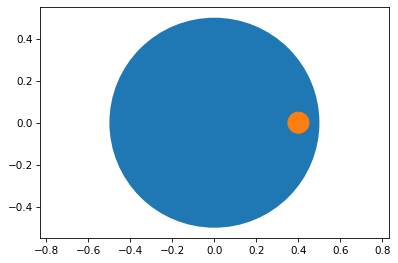

In [21]:
from matplotlib.patches import Circle
from matplotlib.pyplot import gca, axis

def draw_func(t, state):
    theta, omega = state

    # draw a circle for the table
    circle1 = Circle([0, 0], radius_disk)
    gca().add_patch(circle1)

    # draw a circle for the teapot
    center = pol2cart(theta, radius_pot)
    circle2 = Circle(center, 0.05, color='C1')
    gca().add_patch(circle2)

    axis('equal')
state = results.iloc[0]
draw_func(0, state)

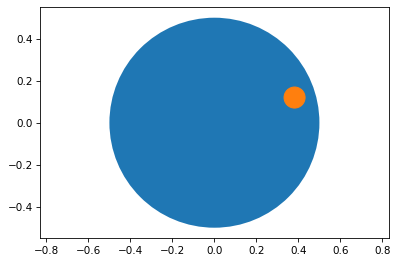

In [22]:
animate(results, draw_func)

Exercises

Exercise 1

In [23]:
system3 = system.set(torque_friction=actual_friction)

In [24]:
remaining_angle = theta_target - theta_test
remaining_angle

1.6415926535897931

In [25]:
def error_func2(force, system):
    results = run_two_phases(force, system.torque_friction, system)
    theta_final = results.iloc[-1].theta
    print(force, theta_final)
    return theta_final - remaining_angle
guess1 = 2.0
error_func2(guess1, system3)

2.0 1.5000060000239976


-0.14158665356579547

In [26]:
guess2 = 3.0
error_func2(guess2, system3)

3.0 2.250009000035999


0.608416346446206

In [27]:
res = root_scalar(error_func2, system3, bracket=[guess1, guess2])

2.0 1.5000060000239976
2.0 1.5000060000239976
3.0 2.250009000035999
2.1887814496255746 1.641592653589789
2.188890888699056 1.6416747332232227


In [28]:
force = res.root
results = run_two_phases(force, actual_friction, system3)
theta_final = results.iloc[-1].theta
print(theta_final + theta_test, theta_target)

3.1415926535897887 3.141592653589793
